## AuxTel test LTS-337-015 (Small Slew and Settle)

In this notebook, we check the speed and accuracy of the slew and settle of the telescope with a
change of 10 degrees.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The pointing accuracy requirement for small slews is:    | 2.5       | Arcsec RMS   |Aux_Tel_Sm_Slew_Abs_Pointing|
The small elevation slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement| 10| Degrees |Aux_Tel_Sm_Elev_Slew|
|The small azimuth slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement.  |10       | Degrees     |Aux_Tel_Sm_Az_Slew|
|The allotted time to perform a slew and settle by Aux_Tel_Sm_Elev_Slew and Aux_Tel_Sm_Az_Slew by the Auxiliary Telescope and meet the Aux_Tel_Sm_Slew_Abs_Pointing pointing requirement.      | 10|Seconds|Aux_Tel_Smslew_AcqTime|

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lsst.ts import salobj
from lsst.ts.observatory.control.auxtel.atcs import ATCS
from lsst.ts.observatory.control.auxtel.latiss import LATISS
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from lsst_efd_client import EfdClient, merge_packed_time_series

INFO:lsst.ts.utils.tai:Update leap second table
INFO:lsst.ts.utils.tai:current_tai uses the system TAI clock


In [2]:
# Set Cerro Pachon location
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [4]:
# for tab completion to work in current notebook instance
%config IPCompleter.use_jedi = False

In [5]:
import logging
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [6]:
# Get EFD client and bring in Lupton's unpacking code
client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253
Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 160
Starting new HTTPS connection (1): influxdb-summit-efd.lsst.codes:443
https://influxdb-summit-efd.lsst.codes:443 "GET /health HTTP/1.1" 200 106


In [7]:
#get classes and start them
domain = salobj.Domain()
await asyncio.sleep(10) # This can be removed in the future...
atcs = ATCS(domain)
latiss = LATISS(domain)
await asyncio.gather(atcs.start_task, latiss.start_task)

atmcs: Adding all resources.
atptg: Adding all resources.
ataos: Adding all resources.
atpneumatics: Adding all resources.
athexapod: Adding all resources.
atdome: Adding all resources.
atdometrajectory: Adding all resources.
atcamera: Adding all resources.
atspectrograph: Adding all resources.
atheaderservice: Adding all resources.
atarchiver: Adding all resources.
Read historical data in 0.01 sec
Read 3 history items for RemoteEvent(ATPneumatics, 0, appliedSettingsMatchStart)
Read 11 history items for RemoteEvent(ATPneumatics, 0, cellVentsState)
Read 1 history items for RemoteEvent(ATPneumatics, 0, eStop)
Read 100 history items for RemoteEvent(ATPneumatics, 0, heartbeat)
Read 8 history items for RemoteEvent(ATPneumatics, 0, instrumentState)
Read 47 history items for RemoteEvent(ATPneumatics, 0, m1CoverLimitSwitches)
Read 21 history items for RemoteEvent(ATPneumatics, 0, m1CoverState)
Read 100 history items for RemoteEvent(ATPneumatics, 0, m1SetPressure)
Read 5 history items for Remot

[[None, None, None, None, None, None, None], [None, None, None, None]]

mountPositions DDS read queue is filling: 25 of 100 elements


In [8]:
# enable components if required
await atcs.enable()
await latiss.enable()

Enabling all components
Gathering settings.
Couldn't get settingVersions event. Using empty settings.
Complete settings for atmcs.
Complete settings for atptg.
Complete settings for ataos.
Complete settings for atpneumatics.
Complete settings for athexapod.
Complete settings for atdome.
Complete settings for atdometrajectory.
Settings versions: {'atmcs': '', 'atptg': '', 'ataos': 'current', 'atpneumatics': '', 'athexapod': 'current', 'atdome': 'current', 'atdometrajectory': ''}
[atmcs]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atptg]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[ataos]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atpneumatics]::[<State.ENABLED: 2>]
[athexapod]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atdome]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atdometrajectory]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
All components in <State.ENABLED: 2>.


In [9]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [57]:
# turn on ATAOS corrections just to make sure the mirror is under air
tmp = await atcs.rem.ataos.cmd_enableCorrection.set_start(m1=True, hexapod=True, atspectrograph=False)

In [11]:
# Ensure we're using Nasmyth 2
await atcs.rem.atptg.cmd_focusName.set_start(focus=3)

In [66]:
# point telescope to desired starting position
start_az=0
start_el=70
start_rot_pa=0
#await atcs.point_azel(start_az, start_el, rot_tel=start_rot_pa, wait_dome=False)

In [13]:
#declare offset sizes for tests

# For small slew and settle
d_az= 10 # degrees
d_el = 10 # degrees
d_rot= 0 # degrees

"""
# For large slew and settle
d_az= 90 # degrees
d_el = 60 # degrees
d_rot= 0 # degrees

# What we actually care about for the survey! So measure this too
d_az= 3.5 # degrees
d_el = 3.5 # degrees
d_rot= 0 # degrees
"""

'\n# For large slew and settle\nd_az= 90 # degrees\nd_el = 60 # degrees\nd_rot= 0 # degrees\n\n# What we actually care about for the survey! So measure this too\nd_az= 3.5 # degrees\nd_el = 3.5 # degrees\nd_rot= 0 # degrees\n'

In [79]:
# get RA/DEC of current telescope Alt/Az position
az = Angle(start_az, unit=u.deg)
el = Angle(start_el, unit=u.deg)
print(f'orig az {az} and el {el}')
time_data = await atcs.rem.atptg.tel_timeAndDate.next(flush=True, timeout=2)
# This should be TAI and not UTC... so will be 37s off system clock seconds ??
curr_time_atptg = Time(time_data.mjd, format="mjd")

coord_frame_AltAz = AltAz(location=location, obstime=curr_time_atptg)
coord_frame_radec = ICRS()
coord_azel = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec = coord_azel.transform_to(coord_frame_radec)
print('Current Position is: \n {}'.format(coord_azel))
print('Current Position is: \n {}'.format(ra_dec))

# get RA/DEC of target position
az = Angle(start_az+d_az, unit=u.deg)
el = Angle(start_el+d_el, unit=u.deg)
print(f'target az {az} and el {el}')
coord_azel_target = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec_target = coord_azel_target.transform_to(coord_frame_radec)
print('Target Position is: \n {}'.format(coord_azel_target))
print('Target Position is: \n {}'.format(ra_dec_target))




orig az 0.0 deg and el 70.0 deg
Current Position is: 
 <AltAz Coordinate (obstime=59479.68613616776, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (0., 70.)>
Current Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (177.74466878, -10.12779911)>
target az 10.0 deg and el 80.0 deg
Target Position is: 
 <AltAz Coordinate (obstime=59479.68613616776, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (10., 80.)>
Target Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (179.58801459, -20.26680276)>


Signature: atcs.azel_from_radec(ra, dec, time=None)
Docstring:
Calculate Az/El coordinates from RA/Dec in ICRS.

Parameters
----------
ra : `float`, `str` or `astropy.coordinates.Angle`
    Target RA, either as a float (hour), a sexagesimal string
    (HH:MM:SS.S or HH MM SS.S) coordinates or
    `astropy.coordinates.Angle`.
dec : `float`, `str` or `astropy.coordinates.Angle`
    Target Dec, either as a float (deg), a sexagesimal string
    (DD:MM:SS.S or DD MM SS.S) coordinates or
    `astropy.coordinates.Angle`.
time : `astropy.time.core.Time` or `None`, optional
    The time which the coordinate trasformation is intended for. If
    `None` (default) use current time.

Returns
-------
azel : `astropy.coordinates.AltAz`
    Astropy coordinates with azimuth and elevation.
File:      ~/auto-op-env-packages/ts_observatory_control/python/lsst/ts/observatory/control/base_tcs.py
Type:      method


In [62]:
# Slew to starting position and take an image to check headers
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)


Auto sky angle: 0.0 deg
Sending command
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
Got False
Telescope not in position
[Telescope] delta Alt = +000.067 deg; delta Az= +000.154 deg; delta N1 = +000.000 deg; delta N2 = +061.109 deg 
[Telescope] delta Alt = +000.000 deg; delta Az= -000.013 deg; delta N1 = +000.000 deg; delta N2 = +058.536 deg 
[Telescope] delta Alt = +000.001 deg; delta Az= -000.012 deg; delta N1 = +000.000 deg; delta N2 = +052.564 deg 
[Telescope] delta Alt = +000.001 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = +046.600 deg 
[Telescope] delta Alt = +000.001 deg; delta Az= -000.012 deg; delta N1 = +000.000 deg; delta N2 = +042.637 deg 
[Telescope] delta Alt = +000.001 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = +036.650 deg 
[Telescope] delta Alt = +000.001 deg; delta Az= -000.012 de

array([2021092200008])

In [ ]:
# Check tracking. Does not work Chec
end_time = Time(Time.now(), format='fits', scale='tai')
t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
await asyncio.sleep(6)
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]

In [19]:
# Errors in arcsec
ra_accuracies = []
dec_accuracies = []

ra_rms = np.sqrt(np.mean((ra_vals - ra_dec_target.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec_target.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")


RA rms = 718820.1127277525. Dec rms = 35724.383411474366.


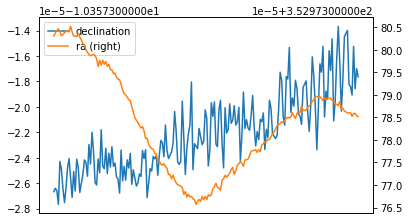

In [24]:
dec['declination'].plot(legend=True)
ra['ra'].plot(legend=True, secondary_y=True)
plt.savefig("radec1.jpg")

In [21]:
az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)

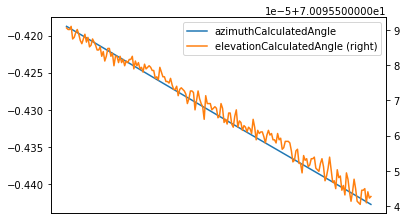

In [25]:
az['azimuthCalculatedAngle'].plot(legend=True)
el['elevationCalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("azel1.jpg")

In [ ]:
len(dec_vals)

In [26]:
dec_time_vals = np.array(dec.values.tolist())[:,1]
ra_time_vals = np.array(ra.values.tolist())[:,1]

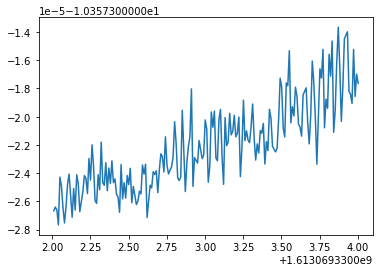

In [27]:
plt.plot(dec_time_vals, dec_vals)

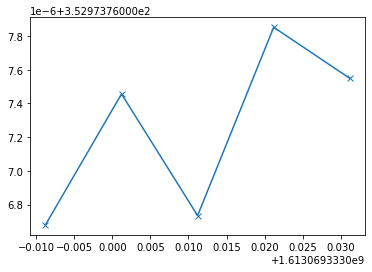

In [28]:
plt.plot(ra_time_vals[98:103], ra_vals[98:103], marker='x')

In [ ]:
ra_vals[98:103]

In [ ]:
new_dec_vals = np.zeros([500])
new_ra_vals = np.zeros([500])
for i in range(5):
    for j in range(100):
        index = i * 100 + j
        new_index = i * 100 + (99 - j)
        if i % 2 == 0:
            new_dec_vals[index] = dec_vals[new_index]
            new_ra_vals[index] = ra_vals[new_index]
        else:
            new_dec_vals[index] = dec_vals[index]
            new_ra_vals[index] = ra_vals[index]

    

In [ ]:
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.7)
plt.title("Dec Values")
plt.plot(dec_time_vals, dec_vals)
plt.subplot(2,1,2)
plt.title("Dec Values with order of even seconds reversed")
plt.plot(dec_time_vals, new_dec_vals)
plt.savefig("/home/craiglagegit/DATA/Dec_Reversal_11Feb21.pdf")

In [ ]:
plt.plot(dec_time_vals, new_ra_vals)

In [ ]:
t1 = Time('2021-02-11T15:58:18.533', scale='tai')
t2 = t1 + TimeDelta(1, format='sec', scale='tai')
df = await client.select_time_series('lsst.sal.ATPtg.mount_positions', '*', t1, t2)


In [ ]:
print(df['ra99'],df['ra0'])

In [54]:
# This is where the tests are carried out.
times = []
ra_accuracies = []
dec_accuracies = []

# Slew to starting position
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)

# Now slew to new target
print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec_target.ra), dec=str(ra_dec_target.dec),
                      rot=d_rot, slew_timeout=240., 
                      stop_before_slew=False, wait_settle=False)
end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                        atcs.radec_from_azel         t_end - TimeDelta(nsec, format='sec'), t_end)
# ra = merge_packed_time_series(mount_position, 'ra', stride=1)
# dec = merge_packed_time_series(mount_position, 'declination', stride=1)
# ra_vals = np.array(ra.values.tolist())[:,0]
# dec_vals = np.array(dec.values.tolist())[:,0]
# # Errors in arcsec
# ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec_target.ra.value)**2)) * 3600.0 
# dec_rms = np.sqrt(np.mean((dec_vals - ra_dec_target.dec.value)**2)) * 3600.0 
# ra_accuracies.append(ra_rms)
# dec_accuracies.append(dec_rms)
# print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")

# Repeat this going back to origin

print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)

end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
# ra = merge_packed_time_series(mount_position, 'ra', stride=1)
# dec = merge_packed_time_series(mount_position, 'declination', stride=1)
# ra_vals = np.array(ra.values.tolist())[:,0]
# dec_vals = np.array(dec.values.tolist())[:,0]
# # Errors in arcsec
# ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec.ra.value)**2)) * 3600.0 
# dec_rms = np.sqrt(np.mean((dec_vals - ra_dec.dec.value)**2)) * 3600.0 
# ra_accuracies.append(ra_rms)
# dec_accuracies.append(dec_rms)
# print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")



Auto sky angle: 0.0 deg
Sending command
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -000.001 deg; delta Az= -000.017 deg; delta N1 = +000.000 deg; delta N2 = +000.005 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.011 deg; delta N1 = -000.000 deg; delta N2 = -000.000 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.011 deg; delta N1 = -000.000 deg; delta N2 = +000.000 deg 
[Telescope] delta Alt = -000.002 deg; delta Az= -000.022 deg; delta N1 = +000.000 deg; delta N2 = +000.008 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2 = -000.000 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2 = -000.000 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2

CancelledError: 

In [ ]:
# Now check to see if the specs are met:
Aux_Tel_Smslew_AcqTime = 10.0
if max(times) < Aux_Tel_Smslew_AcqTime:
    print(f"Aux_Tel_Smslew_AcqTime passed.  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")
else:
    print(f"Aux_Tel_Smslew_AcqTime failed!  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")

Aux_Tel_Sm_Slew_Abs_Pointing = 2.5
worst_case = max(ra_accuracies + dec_accuracies)
if worst_case < Aux_Tel_Sm_Slew_Abs_Pointing:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing passed.  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")
else:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing failed!  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")


In [ ]:
#await salobj.set_summary_state(atcs.rem.atptg, salobj.State.STANDBY)

In [ ]:
#await salobj.set_summary_state(atcs.rem.atmcs, salobj.State.STANDBY)

In [68]:
# For shutdown of system
await atcs.stop_tracking()

Stop tracking.
Tracking state: <AtMountState.TRACKINGENABLED: 9>
Tracking state: <AtMountState.STOPPING: 10>
In Position: True.


In [69]:
# turn off corrections
tmp = await atcs.rem.ataos.cmd_disableCorrection.set_start(m1=True, hexapod=True, atspectrograph=True)

In [70]:
# Putting everything back in standby.
await atcs.shutdown()

Disabling ATAOS corrections
Disabling ATAOS corrections.
Closing M1 cover vent gates.
Cover state <MirrorCoverState.CLOSED: 6>
M1 cover already closed.
M1 vent state <VentsPosition.CLOSED: 1>
M1 vents already closed.
Skipping closing dome shutter and slewing dome to park position.
Dome trajectory check disable. Will not disable following.
Slew telescope to Park position.
Sending command
Stop tracking.
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = +009.820 deg; delta Az= -007.781 deg; delta N1 = +000.000 deg; delta N2 = -063.315 deg 
[Telescope] delta Alt = +009.820 deg; delta Az= -007.781 deg; delta N1 = -000.000 deg; delta N2 = -063.315 deg 
[Telescope] delta Alt = +008.880 deg; delta Az= -006.506 deg; delta N1 = +000.000 deg; delta N2 = -061.646 deg 
[Telescope] delta Alt = +005.649 deg; delta Az= -002.833 deg; delt

In [71]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [ ]:
await atcs.rem.atdome.cmd_start.set_start(settingsToApply="test", timeout=30)

In [72]:
await salobj.set_summary_state(atcs.rem.atdome, salobj.State.STANDBY, settingsToApply="test")

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [73]:
await salobj.set_summary_state(atcs.rem.atdometrajectory, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [74]:
await salobj.set_summary_state(latiss.rem.atspectrograph, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atcamera, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atheaderservice, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atarchiver, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [40]:
await atcs.enable()

Enabling all components
Gathering settings.
atdome check is disabled, skipping.
atdometrajectory check is disabled, skipping.
[Telescope] delta Alt = -000.000 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = -000.000 deg; delta N2 = +000.010 deg 
Couldn't get settingVersions event. Using empty settings.
Complete settings for atmcs.
Complete settings for atptg.
Complete settings for ataos.
Complete settings for atpneumatics.
Complete settings for athexapod.
Settings versions: {'atmcs': '', 'atptg': '', 'ataos': 'current', 'atpneumatics': '', 'athexapod': 'current'}
[atmcs]::[<State.ENABLED: 2>]
[atptg]::[<State.ENABLED: 2>]
[ataos]::[<State.ENABLED: 2>]
[atpneumatics]::[<State.ENABLED: 2>]
[athexapod]::[<State.ENABLED: 2>]
[atdome]::<State.ENABLED: 2>
[atdometrajectory]::<Sta

In [50]:
# This is where the tests are carried out.
times = []
ra_rms_accuracies = []
dec_rms_accuracies = []
ra_mean_accuracies = []
dec_mean_accuracies = []

# Slew to starting position
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0, slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take an image
await latiss.take_engtest(exptime=2)

# Now slew to new target
print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec_target.ra), dec=str(ra_dec_target.dec),
                      rot=d_rot, slew_timeout=240., 
                      stop_before_slew=False, wait_settle=False)
end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=2)
await asyncio.sleep(5)
t_end = end_time + TimeDelta(5, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['ra', 'declination'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]

ra_mean = np.mean(ra_vals)
dec_mean = np.mean(dec_vals)
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals - ra_mean)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - dec_mean)**2)) * 3600.0 
ra_mean_error = abs(ra_dec.ra.value - ra_mean) * 3600
dec_mean_error = abs(ra_dec.dec.value - dec_mean) * 3600
print(f"RA rms error= {ra_rms} arcseconds. Dec rms error= {dec_rms} arcseconds.")
print(f"RA mean error = {ra_mean_error} arcseconds. Dec mean error = {dec_mean_error} arcseconds.")

ra_rms_accuracies.append(ra_rms)
dec_rms_accuracies.append(dec_rms)
ra_mean_accuracies.append(ra_mean_error)
dec_mean_accuracies.append(dec_mean_error)

# Repeat this going back to origin

print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)

end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=2)
await asyncio.sleep(5)
t_end = end_time + TimeDelta(5, format='sec')
nsec = 2
mount_position = await client.select_packed_time_series("lsst.sal.ATPtg.mount_positions", ['ra', 'declination'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
#ra = merge_packed_time_series(mount_position, 'ra', stride=1)
#dec = merge_packed_time_series(mount_position, 'declination', stride=1)
#ra_vals = np.array(ra.values.tolist())[:,0]
#dec_vals = np.array(dec.values.tolist())[:,0]
# ra_mean = np.mean(ra_vals)
# dec_mean = np.mean(dec_vals)
# # Errors in arcsec
# ra_rms = np.sqrt(np.mean((ra_vals - ra_mean)**2)) * 3600.0 
# dec_rms = np.sqrt(np.mean((dec_vals - dec_mean)**2)) * 3600.0 
# ra_mean_error = abs(ra_dec.ra.value - ra_mean) * 3600
# dec_mean_error = abs(ra_dec.dec.value - dec_mean) * 3600
# print(f"RA rms error= {ra_rms} arcseconds. Dec rms error= {dec_rms} arcseconds.")
# print(f"RA mean error = {ra_mean_error} arcseconds. Dec mean error = {dec_mean_error} arcseconds.")

# ra_rms_accuracies.append(ra_rms)
# dec_rms_accuracies.append(dec_rms)
# ra_mean_accuracies.append(ra_mean_error)
# dec_mean_accuracies.append(dec_mean_error)


Auto sky angle: 0.0 deg
Sending command
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
Got False
Telescope not in position
[Telescope] delta Alt = -010.154 deg; delta Az= -007.050 deg; delta N1 = -000.000 deg; delta N2 = -003.820 deg 
[Telescope] delta Alt = -009.815 deg; delta Az= -006.380 deg; delta N1 = +000.000 deg; delta N2 = -001.750 deg 
[Telescope] delta Alt = -007.393 deg; delta Az= -002.996 deg; delta N1 = +000.000 deg; delta N2 = -000.001 deg 
[Telescope] delta Alt = -003.534 deg; delta Az= -000.234 deg; delta N1 = -000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.653 deg; delta Az= -000.023 deg; delta N1 = +000.000 deg; delta N2 = +000.010 deg 
Got True
Telescope in position.
track for 2s
Generating group_id
imagetype: ENGTEST, skip TCS synchronization.
ENGTEST 0001 - 0001
Starting to Slew to target
Auto sky angl

KeyError: 'cRIO_timestamp'

In [45]:
await atcs.reset_offsets()

Reseting absorbed offsets.
Reseting non-absorbed offsets.
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2 = -000.001 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = -000.001 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = -000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.001 deg; delta Az= -000.023 deg; delta N1 = +000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = -000.000 deg; delta N2 = -000.001 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = +000.010 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.012 deg; delta N1 = -000.000 deg; delta N2 = -000.000 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= -000.011 deg; delta N1 = +000.000 deg; delta N2 = +000.009 deg 
[Telescope] delta Alt = -000.000 deg; delta Az

In [100]:
ahorita = Time(Time.now())
print('el tiempo ahora es', ahorita)
entai = Time(Time.now(),scale='tai')
print('en TAI es' , entai)
utc_coord =  atcs.radec_from_azel(az=0,el=80, time = ahorita)
tai_coord = atcs.radec_from_azel(az=0,el=80, time = entai)
print(utc_coord)
print(tai_coord)

el tiempo ahora es 2021-09-22 17:23:25.166391
en TAI es 2021-09-22 17:24:02.167490
<ICRS Coordinate: (ra, dec) in deg
    (191.61908222, -20.12942672)>
<ICRS Coordinate: (ra, dec) in deg
    (191.61908681, -20.12942672)>


In [107]:
utc_coord.ra.deg

191.6190822227351

In [108]:
tai_coord.ra.deg

191.61908681090867

In [111]:
atcs.slew_object?

Signature:
atcs.slew_object(
    name,
    rot=0.0,
    rot_type=<RotType.SkyAuto: 1>,
    dra=0.0,
    ddec=0.0,
    offset_x=0.0,
    offset_y=0.0,
    az_wrap_strategy=None,
    time_on_target=0.0,
    slew_timeout=240.0,
)
Docstring:
Slew to an object name.

Use simbad to resolve the name and get coordinates.

Parameters
----------
name : `str`
    Target name.
rot : `float`, `str` or `astropy.coordinates.Angle`, optional
    Specify desired rotation angle. Strategy depends on `rot_type`
    parameter. Accepts float (deg), sexagesimal string (DD:MM:SS.S or
    DD MM SS.S) coordinates or `astropy.coordinates.Angle`
rot_type :  `lsst.ts.observatory.control.utils.RotType`, optional
    Rotation type. This parameter defines how `rot_value` is threated.
    Default is `SkyAuto`, the rotator is positioned with respect to the
    North axis and is automacally wrapped if outside the limit. See
    `RotType` for more options.
slew_timeout : `float`, optional
    Timeout for the slew command

In [32]:
tStart = Time('2021-09-08T22:30:18.533', scale='tai')
tEnd = tStart + TimeDelta(30, format='sec', scale='tai')

client = EfdClient('summit_efd')
t_start = Time(tStart, scale='tai')
t_end = Time(tEnd, scale='tai')
mount_position = await client.select_time_series("lsst.sal.ATPtg.mountPositions", ['*'], t_start, t_end)
az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', ref_timestamp_col="cRioTimestamp")
#mount_position.columns 

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [25]:
#mount_position = await client.select_packed_time_series("lsst.sal.ATPtg.mountPositions", "ra", t_start, t_end)
client.select_packed_time_series?

Signature:
client.select_packed_time_series(
    topic_name,
    base_fields,
    start,
    end,
    is_window=False,
    index=None,
    ref_timestamp_col='cRIO_timestamp',
)
Docstring:
Select fields that are time samples and unpack them into a dataframe.

Parameters
----------
topic_name : `str`
    Name of topic to query.
base_fields :  `str` or `list`
    Base field name(s) that will be expanded to query all
    vector entries.
start : `astropy.time.Time`
    Start time of the time range, if ``is_window`` is specified,
    this will be the midpoint of the range.
end : `astropy.time.Time` or `astropy.time.TimeDelta`
    End time of the range either as an absolute time or
    a time offset from the start time.
is_window : `bool`, optional
    If set and the end time is specified as a
    `~astropy.time.TimeDelta`, compute a range centered on the start
    time (default is `False`).
index : `int`, optional
    For indexed topics set this to the index of the topic to query
    (defaul

In [18]:
mount_position

,azimuthCalculatedAngle0,azimuthCalculatedAngle1,azimuthCalculatedAngle10,azimuthCalculatedAngle11,azimuthCalculatedAngle12,azimuthCalculatedAngle13,azimuthCalculatedAngle14,azimuthCalculatedAngle15,azimuthCalculatedAngle16,azimuthCalculatedAngle17,...,skyAngle90,skyAngle91,skyAngle92,skyAngle93,skyAngle94,skyAngle95,skyAngle96,skyAngle97,skyAngle98,skyAngle99
2021-09-08 22:30:18.594000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:19.644000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:20.693000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:21.742000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:22.790000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:23.839000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:24.887000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:25.936000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:26.987000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428
2021-09-08 22:30:28.037000+00:00,0.000041,0.000036,0.000027,0.000025,0.000027,0.000029,0.000032,0.000033,0.000029,0.000029,...,280.138256,280.138362,280.138449,280.138506,280.138507,280.138473,280.138417,280.138388,280.138389,280.138428


In [127]:
mount_position.index

Index([], dtype='object')

In [124]:
print(mount_position)

Empty DataFrame
Columns: []
Index: []
